In [1]:
import os, re
import pandas as pd
import numpy as np
import json
from scipy.stats import ttest_rel,ttest_ind
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from humanUtils import *
## this file contains most of the logic for loading and processing database
from cswHumanDatabase import load_final_df

In [3]:
## load a thresholded dateset
thresh = 0.9
dfD = {}
for cond in ALL_CONDITIONS:
  dfD[cond] = load_final_df(cond,threshold=thresh) 


-loading code version: RT01B1000cl
N = 55 subjects

-loading code version: csw1000block01.04.25.19
N = 56 subjects

-loading code version: 1000clq
N = 53 subjects

-loading code version: csw1000block40.04.07.19
N = 63 subjects

-loading code version: csw1000boldmdp.05.09.19
N = 52 subjects

-loading code version: csw1000insertedblock0.09.22.19
N = 51 subjects

-loading code version: csw1000insertedblock0.10.08.19
N = 57 subjects

-loading code version: csw1000insertedblock1.09.30.19
N = 56 subjects

-loading code version: csw1000insertedblock1.10.07.19
N = 51 subjects

-loading code version: csw1000insertedblock2.10.09.19
N = 51 subjects

-loading code version: csw1000insertedblock2.10.10.19
N = 56 subjects


# figures

In [24]:

## herlper for operating pandas dataframes
compute_mean = lambda df_: df_.groupby(['story']).correct_response.mean()
compute_stderr = lambda df_: df_.groupby(['story']).correct_response.std(
  ) / np.sqrt(len(df_.index.get_level_values('subjnum').unique()))

def plot_acc_with_background(df,ax=None,cL=['blue','green','blue','green','red']):
  ## compute mean and stderr
  M = compute_mean(df)
  S = compute_stderr(df)
  ## plot with error shading
  if type(ax)==type(None):
    ax = plt.gca()
  ax.plot(M)
  ax.fill_between(np.arange(len(M)),M-S,M+S,alpha=0.3)
  ## make nice background
  for idx in range(5):
    ax.fill_between(np.arange(40*idx,41+40*idx),0,1.05,color=cL[idx],alpha=0.2)

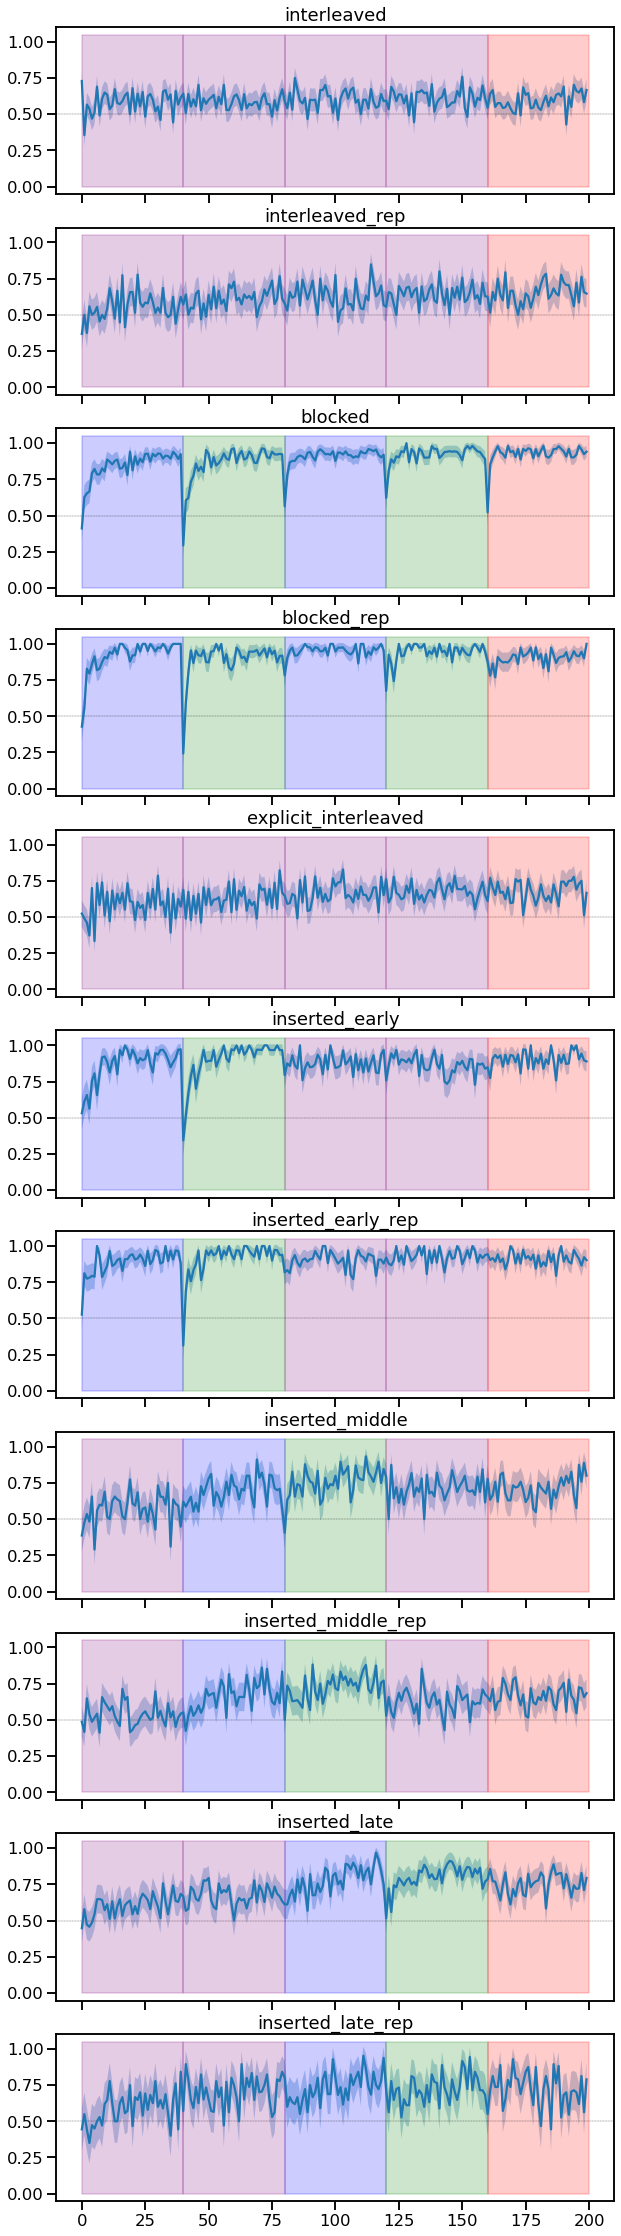

In [31]:
fg,axar = plt.subplots(len(dfD),1,figsize=(10,40),sharex=True);
cLD = {
  'blocked': ['blue','green','blue','green','red'],
  'blocked_rep': ['blue','green','blue','green','red'],
  'interleaved': ['purple','purple','purple','purple','red'],
  'interleaved_rep': ['purple','purple','purple','purple','red'],
  'inserted_early': ['blue','green','purple','purple','red'],
  'inserted_early_rep': ['blue','green','purple','purple','red'],
  'inserted_middle': ['purple','blue','green','purple','red'],
  'inserted_middle_rep': ['purple','blue','green','purple','red'],
  'inserted_late': ['purple','purple','blue','green','red'],
  'inserted_late_rep': ['purple','purple','blue','green','red'],
  'explicit_interleaved': ['purple','purple','purple','purple','red'],
}
for idx,(c_str,c_df) in enumerate(dfD.items()):
  ax = axar[idx]
  ax.set_title(c_str)
  ax.axhline(0.5,c='k',ls='--',lw=.3)
  cL = cLD[c_str]
  plot_acc_with_background(dfD[c_str],cL=cL,ax=ax)

# stats

## between conditions

In [4]:
## helper for pulling mean test acc for each subject
get_test_df = lambda df: df[df.index.get_level_values('block') == 4]
## compute ttest
def tstat_betweencond_testacc(df1,df2):
  """ independent samples t-test
  test acc of two conditions
  """
  sub_testacc_df1 = get_test_df(df1).groupby(['subjnum']).correct_response.mean()
  sub_testacc_df2 = get_test_df(df2).groupby(['subjnum']).correct_response.mean()
  return ttest_ind(sub_testacc_df1,sub_testacc_df2)

In [5]:
import itertools
big_str = ""
for (c1,df1),(c2,df2) in itertools.product(dfD.items(),dfD.items()):
  t,p = tstat_betweencond_testacc(df1,df2)
  smal_str = "%s vs %s\n ttest_ind=%s, p=%s"%(c1,c2,t,p)
  print(smal_str)
  big_str += "\n%s"%smal_str

with open('stats_reports/between_condition_test_acc.txt', 'w') as f:
    f.write(big_str)

interleaved vs interleaved
 ttest_ind=0.0, p=1.0
interleaved vs interleaved_rep
 ttest_ind=-1.2008384764920985, p=0.23445613558147502
interleaved vs blocked
 ttest_ind=-9.916403442900622, p=4.872603296865684e-15
interleaved vs blocked_rep
 ttest_ind=-8.245386732486837, p=1.3291029501489201e-11
interleaved vs explicit_interleaved
 ttest_ind=-2.0382399416210997, p=0.045417604902215164
interleaved vs inserted_early
 ttest_ind=-7.650889257929391, p=2.360602522228711e-10
interleaved vs inserted_early_rep
 ttest_ind=-8.484411491308558, p=8.338362249700803e-12
interleaved vs inserted_middle
 ttest_ind=-2.490690336544512, p=0.015686919508189973
interleaved vs inserted_middle_rep
 ttest_ind=-1.5970959178611723, p=0.11541226435964222
interleaved vs inserted_late
 ttest_ind=-3.4152676298137243, p=0.0011385487133550563
interleaved vs inserted_late_rep
 ttest_ind=-2.4041474731039814, p=0.02003634762589913
interleaved_rep vs interleaved
 ttest_ind=1.2008384764920985, p=0.23445613558147502
interleave

## within condition between timesteps

In [6]:
## helper for pulling mean test acc on specified tstep for each subject
get_tstep_df = lambda tstep,df: df[df.index.get_level_values('depth') == tstep]
# compute stat
def tstat_wicond_betweenstep_testacc(df):
  """ related samples t-test
  test acc step 1 vs step 2
  """
  # step 1
  sub_testacc_step1 = get_tstep_df(1,get_test_df(df)
                    ).groupby(['subjnum']).correct_response.mean()
  # step 2
  sub_testacc_step2 = get_tstep_df(2,get_test_df(df)
                    ).groupby(['subjnum']).correct_response.mean()

  return ttest_rel(sub_testacc_step1,sub_testacc_step2)

In [7]:
big_str2 = ""
for cond_,df_ in dfD.items():
  t,p = tstat_wicond_betweenstep_testacc(df_)
  smal_str2 = "%s step1-vs-step2 \n ttest_rel=%s, p=%s"%(cond_,t,p)
  print(smal_str2)
  big_str2 += "\n%s"%smal_str2

with open('stats_reports/within_condition_between_tstep_testacc.txt', 'w') as f:
    f.write(big_str2)

interleaved step1-vs-step2 
 ttest_rel=-2.9987191842997314, p=0.004762443651739155
interleaved_rep step1-vs-step2 
 ttest_rel=-2.3656924402917, p=0.026802947687417443
blocked step1-vs-step2 
 ttest_rel=-1.4507778943495915, p=0.15628162080472657
blocked_rep step1-vs-step2 
 ttest_rel=-1.1281707842409565, p=0.26995868044946814
explicit_interleaved step1-vs-step2 
 ttest_rel=-1.7993888650199066, p=0.08202376817392028
inserted_early step1-vs-step2 
 ttest_rel=0.5186717553359091, p=0.6096811993029079
inserted_early_rep step1-vs-step2 
 ttest_rel=1.8288625968792827, p=0.08165889595047933
inserted_middle step1-vs-step2 
 ttest_rel=0.2724654019063934, p=0.7882032606346452
inserted_middle_rep step1-vs-step2 
 ttest_rel=-3.6944655460979123, p=0.0011974923739878074
inserted_late step1-vs-step2 
 ttest_rel=-2.464384675248579, p=0.021623410819361966
inserted_late_rep step1-vs-step2 
 ttest_rel=-2.1575245437681687, p=0.05393619026708109
